# Predicting Spotify Song Popularity with PyTorch


## Introduction


The project applies PyTorch, a leading deep learning framework, to the task of predicting Spotify’s popularity score (0–100) for songs based on their audio features. Our goal is to collaboratively build a neural network capable of estimating a song’s popularity using attributes such as danceability, energy, valence, tempo, and more.

By shifting from traditional machine learning approaches to a neural network–based solution, we aim to gain practical experience with an industry-standard tool while addressing a real-world regression problem. The project will involve designing, training, and evaluating multiple network architectures, with a focus on improving performance through iterative experimentation.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import random
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

## Data Preprocessing


In [2]:
# Load the dataset
data = pd.read_csv('dataset/SpotifyFeatures.csv')

In [3]:
# Display the first few rows of the dataset
data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [4]:
# Display the shape of 'data' DataFrame 
n_rows, n_cols = data.shape
print(f"The DataFrame has {n_rows} rows and {n_cols} columns") 

The DataFrame has 232725 rows and 18 columns


In [5]:
# Display informative summary of the 'data' DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [6]:
# Check for any duplicates in the dataframe
duplicates = data[data.duplicated()]
print(f"Number of duplicates: {duplicates.shape[0]}")

Number of duplicates: 0


- It can be observed that there are no duplicates in the data.


In [7]:
# Check for missing values in 'data' DataFrame
display(data.isna().sum())

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

- There are no missing values


In [63]:
# Drop missing values
data = data.dropna()

# Check for missing values again
data.isna().sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

### Removing Irrelevant Features


In [64]:
# Let's remove some obvious irrelevant features
data = data.drop(columns=['track_id', 'track_name', 'artist_name'])

### Dropped Features

- **track_id** → Just a unique identifier; carries no predictive value.
- **track_name** → Song title text; unstructured, very high dimensional, and not meaningful for predicting popularity.
- **artist_name** → Very high cardinality and potential **data leakage**.
  - Popular artists typically have higher popularity.
  - This allows the model to _memorize specific artists_ rather than learning from audio features.

Keeping them may add noise or unnecessary complexity, so we removed them before training the model. By removing them, we keep only meaningful numerical/audio features for training.


In [65]:
# Quick look
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 232724 entries, 0 to 232724
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232724 non-null  object 
 1   popularity        232724 non-null  int64  
 2   acousticness      232724 non-null  float64
 3   danceability      232724 non-null  float64
 4   duration_ms       232724 non-null  int64  
 5   energy            232724 non-null  float64
 6   instrumentalness  232724 non-null  float64
 7   key               232724 non-null  object 
 8   liveness          232724 non-null  float64
 9   loudness          232724 non-null  float64
 10  mode              232724 non-null  object 
 11  speechiness       232724 non-null  float64
 12  tempo             232724 non-null  float64
 13  time_signature    232724 non-null  object 
 14  valence           232724 non-null  float64
dtypes: float64(9), int64(2), object(4)
memory usage: 28.4+ MB


## Exploratory Data Analysis(EDA)


### Exploring the Distribution of Numerical Features

Before building the model, it’s important to understand how each numerical feature is distributed.  
This helps us:

- Detect skewness or outliers
- Identify features that may need scaling or transformation
- Get an overall sense of the dataset’s structure

We will plot histograms for each numerical column in the dataset.


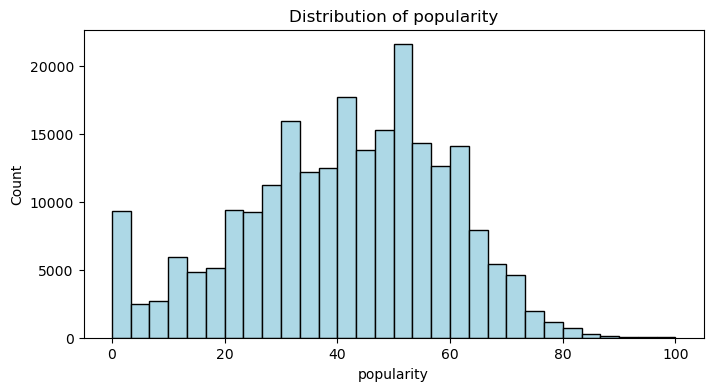

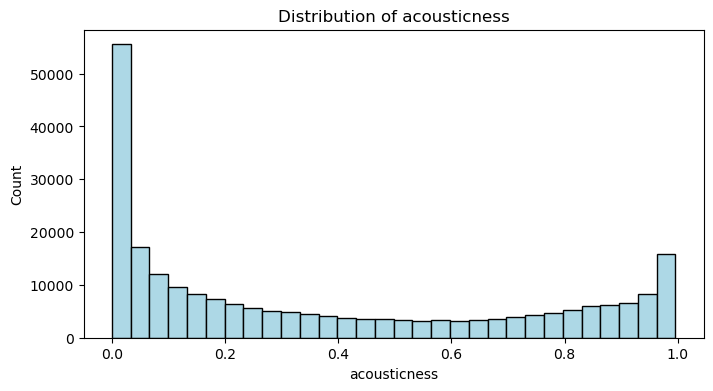

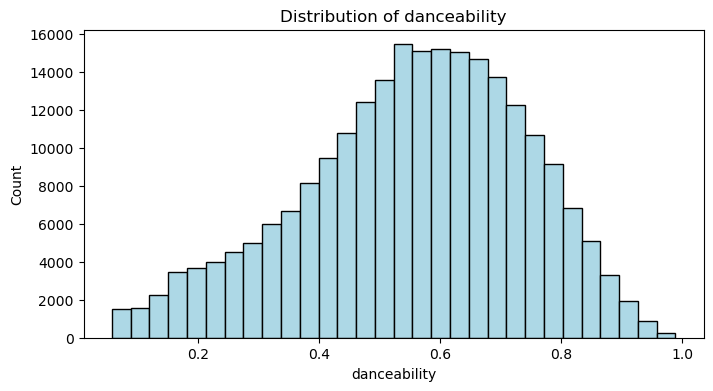

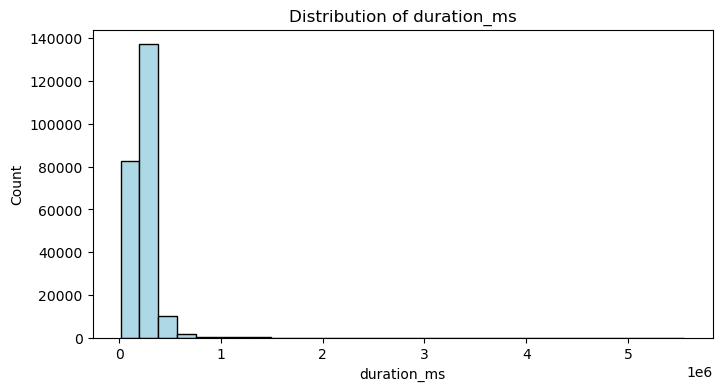

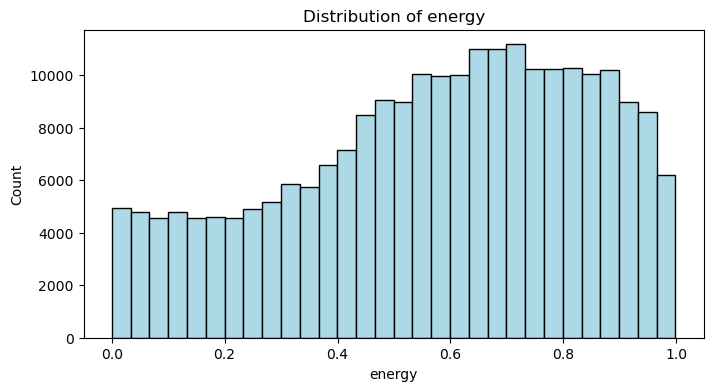

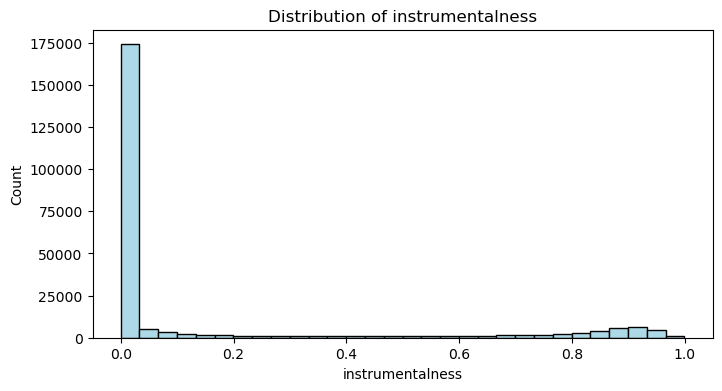

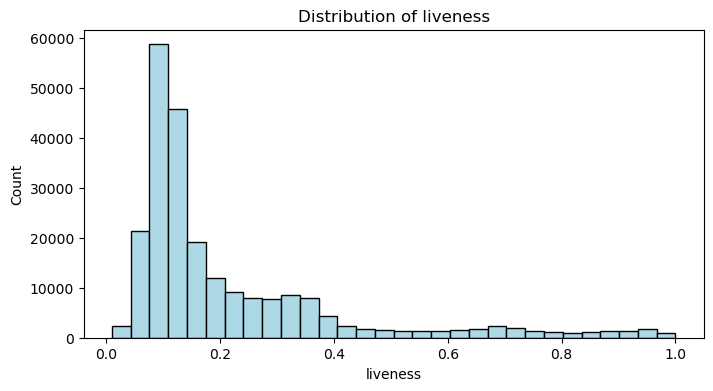

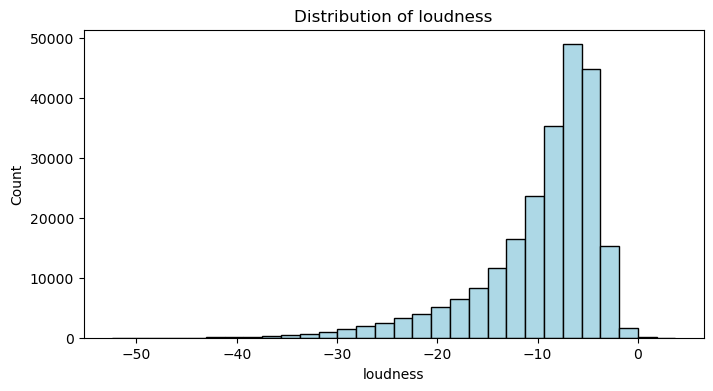

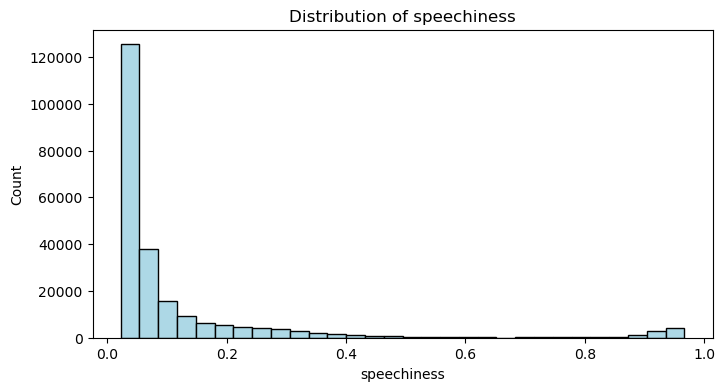

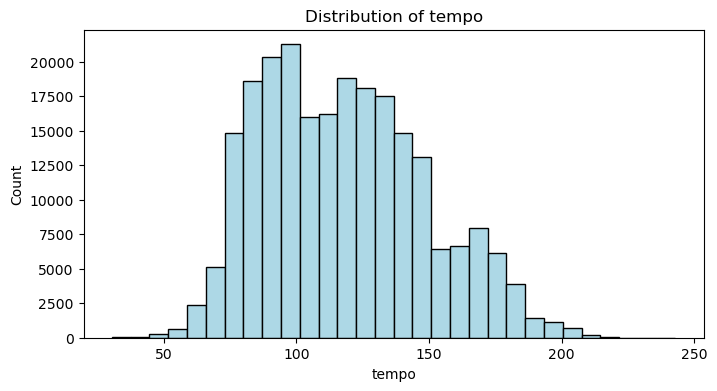

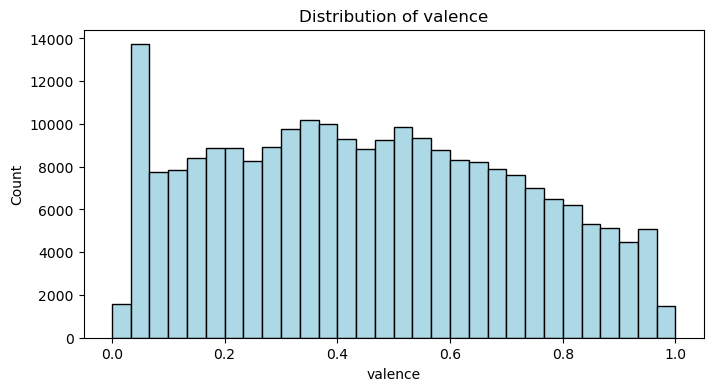

In [66]:
# Lets explore the distribution of numerical features

# Select numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

for one_col in numeric_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(data[one_col], bins=30, color='lightblue', edgecolor='black')
    plt.title(f'Distribution of {one_col}')
    plt.xlabel(one_col)
    plt.ylabel('Count')
    plt.show()

The feature `duration_ms` distribution is too extreme. So it is better to log tranform that.


In [8]:
# log transform 
data['duration_ms_log'] = np.log1p(data['duration_ms'])

# drop original column
data = data.drop(columns=['duration_ms'])

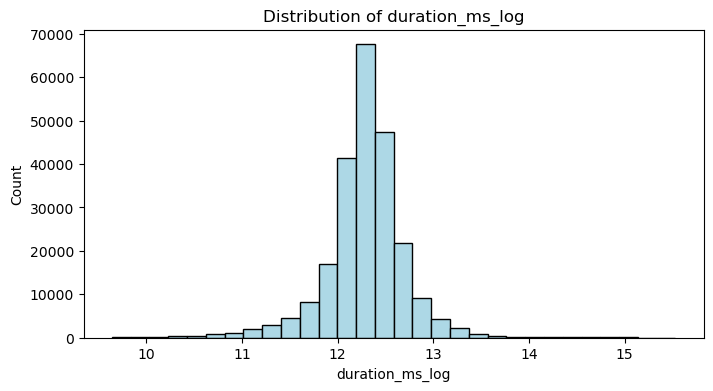

In [9]:
# Distribution after log transformation
plt.figure(figsize=(8, 4))
plt.hist(data['duration_ms_log'], bins=30, color='lightblue', edgecolor='black')
plt.title('Distribution of duration_ms_log')
plt.xlabel('duration_ms_log')
plt.ylabel('Count')
plt.show()

- Now, the data is normally distributed.


In [10]:
# Lets explore some categorical columns
# `time_signature` feature

data['time_signature'].value_counts()

4/4    200760
3/4     24111
5/4      5238
1/4      2608
0/4         8
Name: time_signature, dtype: int64

- In our dataset, **"4/4" dominates**: it accounts for the vast majority of tracks (over 85%).
- Instead of representing all time signatures, we encode as `1` if `time_signature` is "4/4", else `0`.
- This approach **reduces dimensionality and noise**.


In [11]:
# Create a binary column

data['time_signature'] = np.where(data['time_signature'] == '4/4', 1, 0)

# Quick check
data['time_signature'].value_counts()

1    200760
0     31965
Name: time_signature, dtype: int64

In [71]:
# Let's explore `mode`
data['mode'].value_counts()

mode
Major    151743
Minor     80981
Name: count, dtype: int64

We can engineer a feature to create a binary column.


### Converting Categorical Column `mode` into Binary

The `mode` column indicates whether a track is in a **Major** or **Minor** key.  
Since machine learning models work better with numerical features, we map:

- `Major` → 1
- `Minor` → 0

This creates a binary representation that can be used directly in training.


In [12]:
# Create a binary column
data['mode'] = data['mode'].map({'Major': 1, 'Minor': 0})

# Quick check
data['mode'].value_counts()

1    151744
0     80981
Name: mode, dtype: int64

In [13]:
# Explore `key`
data['key'].value_counts()

C     27583
G     26390
D     24077
C#    23201
A     22671
F     20279
B     17661
E     17390
A#    15526
F#    15222
G#    15159
D#     7566
Name: key, dtype: int64

In [14]:
# Explore `genre`
data['genre'].value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: genre, dtype: int64

The `key` feature has 12 unique values and genre has 25+ unique values. If we apply one-hot encoding, it will add more dimensions and increase the complexity of the model. Since we want to focus on music attributes, we will remove these high-cardinality categorical features.


In [15]:
# Remove `key` and `genre`
data = data.drop(columns=['key', 'genre'])

# Quick check
data.columns

Index(['artist_name', 'track_name', 'track_id', 'popularity', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'mode', 'speechiness', 'tempo', 'time_signature', 'valence',
       'duration_ms_log'],
      dtype='object')

### Feature Engineering: Energy × Danceability

On platforms like Instagram Reels and TikTok, **high-energy and highly danceable songs** are more likely to trend and gain popularity.  
To capture this interaction effect, we create a new feature:

$$
energy\_danceability = energy \times danceability
$$

This combines two related attributes into a single feature that may improve the model’s predictive power.


In [18]:
# High-energy danceable songs tend to be more popular in reels and tiktok. Let's do feature engineering
data['energy_danceability'] = data['energy'] * data['danceability']

### Correlation Heatmap for Numeric Features

To check for **multicollinearity** (strong correlations between features), we compute the correlation matrix of all numeric columns and visualize it with a heatmap.

This helps us:

- Identify features that are highly correlated with each other
- Detect potential redundancy in the dataset
- Decide whether to drop or transform certain variables before modeling


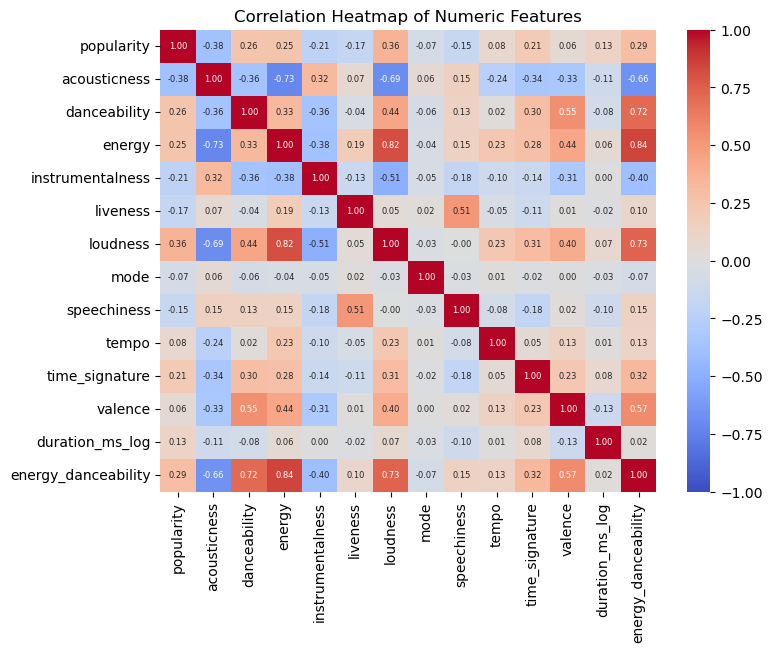

In [77]:
# Create a heat map to see if there is multicollinearity.

# Select numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Correlation matrix
corr_matrix = data[numeric_cols].corr()

# Plot heatmap 
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, 
    annot=True,          
    fmt='.2f',           
    cmap='coolwarm',
    annot_kws={'size': 6},     
    vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

There is no multicollinearity in the data.


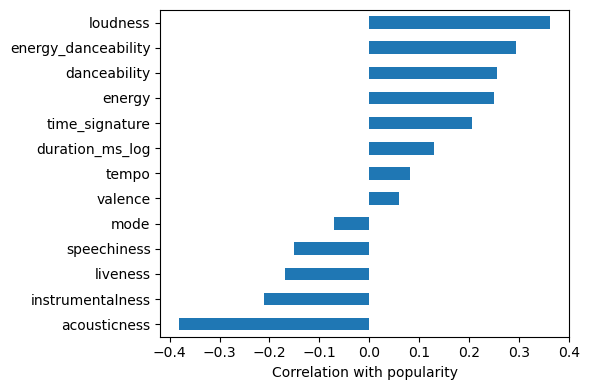

In [78]:
# Let's explore how target is correlated to numeric features

num_features = data.select_dtypes(include='number').columns.drop('popularity')
corr = data[num_features].corrwith(data['popularity']).sort_values()

plt.figure(figsize=(6, 4))
corr.plot.barh()
plt.xlabel('Correlation with popularity')
plt.tight_layout()
plt.show()


Features like loudness, energy_danceability show the strongest positive relationship with popularity, while acousticness is most negatively correlated.


## Model Development


In [79]:
# Set random seeds for reproducible results across runs
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [80]:
# Experiment Configuration
# Hyperparameter search configuration
EPOCHS = 50          # Maximum training epochs per trial
PATIENCE = 5         # Early stopping patience (epochs without improvement)
N_TRIALS = 25        # Number of random configurations to test

print(f"Experiment setup:")
print(f"- Maximum epochs per model: {EPOCHS}")
print(f"- Early stopping patience: {PATIENCE}")
print(f"- Total random configurations to test: {N_TRIALS}")

Experiment setup:
- Maximum epochs per model: 50
- Early stopping patience: 5
- Total random configurations to test: 25


In [81]:
# Split once, hold out test
# --- Split data ---
# Assumes your DataFrame `data` is already cleaned (e.g., dropped text/high-cardinality cols)
features = data.drop('popularity', axis=1)
target   = data['popularity']

X_temp, X_test, y_temp, y_test = train_test_split(
    features, 
    target, 
    test_size=0.20, 
    random_state=1
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.25, 
    random_state=1
)  # -> 60/20/20 split


In [82]:
# Preprocess with a pipeline
# scale continuous features (good for neural nets), pass through binary flags as-is

# --- Preprocessing ---
binary_features     = ['mode', 'time_signature']  # already 0/1 from your earlier steps
continuous_features = [c 
                       for c in features.columns 
                       if c not in binary_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('continuous', StandardScaler(), continuous_features),
        ('binary', 'passthrough', binary_features),
    ],
    remainder='drop'
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_valid_scaled = preprocessor.transform(X_valid)
X_test_scaled  = preprocessor.transform(X_test)


In [83]:
# Helper: numpy → torch
# consistent dtype/shape handling

# --- To tensors ---
def to_tensor(X, y):
    x_tensor = torch.from_numpy(X).float()
    y_tensor = torch.from_numpy(y.values).float().view(-1, 1)
    return x_tensor, y_tensor

x_train, y_train = to_tensor(X_train_scaled, y_train)
x_valid, y_valid = to_tensor(X_valid_scaled, y_valid)
x_test,  y_test  = to_tensor(X_test_scaled,  y_test)


In [84]:
# A flexible MLP
# same class supports many architectures (we’ll search layer sizes & dropout).
# --- Model ---
class FlexibleNeuralNet(nn.Module):
    def __init__(self, input_size, layer_sizes, dropout):
        super().__init__()
        layers, prev = [], input_size
        for h in layer_sizes:
            layers += [nn.Linear(prev, h), nn.ReLU()]
            if dropout > 0:
                layers += [nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]  # regression head
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [85]:
# Hyperparameter space
# --- Search space ---
layer_options         = [(16,), (32,), (32,16), (64,32), (64,32,16)]
optimizer_options     = ['adam', 'rmsprop']
learning_rate_options = [1e-3, 5e-4, 3e-4, 1e-4]
dropout_options       = [0, 0.1, 0.2, 0.3]
batch_sizes           = [32, 64, 128]


In [86]:
# One trial = train + early stopping on validation
# we track both train and validation. We return train & valid RMSE measured at the best validation checkpoint
# --- Train a single trial (no test here) ---
def run_trial(config):
    input_size = x_train.shape[1]
    model = FlexibleNeuralNet(input_size, config['layers'], config['dropout'])

    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=config['lr'])
    else:
        raise ValueError("Unknown optimizer")

    criterion = nn.MSELoss()
    train_loader = DataLoader(TensorDataset(x_train, y_train),
                              batch_size=config['batch_size'], shuffle=True)
    valid_loader = DataLoader(TensorDataset(x_valid, y_valid),
                              batch_size=config['batch_size'], shuffle=False)

    best_valid_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    train_losses, valid_losses = [], []

    for _ in range(EPOCHS):
        # Train
        model.train()
        total_train = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_train += loss.item() * xb.size(0)
        train_losses.append(total_train / len(train_loader.dataset))

        # Validate
        model.eval()
        total_valid = 0.0
        with torch.no_grad():
            for xb, yb in valid_loader:
                preds = model(xb)
                loss = criterion(preds, yb)
                total_valid += loss.item() * xb.size(0)
        avg_valid = total_valid / len(valid_loader.dataset)
        valid_losses.append(avg_valid)

        # Early stopping
        if avg_valid < best_valid_loss:
            best_valid_loss = avg_valid
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                break

    # Evaluate both Train & Valid at the best checkpoint
    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        train_mse = nn.MSELoss()(model(x_train), y_train).item()
        valid_mse = nn.MSELoss()(model(x_valid), y_valid).item()

    return {
        'config':       config,
        'train_rmse':   np.sqrt(train_mse),
        'valid_rmse':   np.sqrt(valid_mse),
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'state_dict':   best_model_state,  # capture the best weights
    }


In [87]:
# Randomized search
# --- Run randomized trials (report Train & Valid) ---
results = []
for trial in range(N_TRIALS):
    config = {
        'layers':     random.choice(layer_options),
        'optimizer':  random.choice(optimizer_options),
        'lr':         random.choice(learning_rate_options),
        'dropout':    random.choice(dropout_options),
        'batch_size': random.choice(batch_sizes),
    }
    result = run_trial(config)
    print(f"\nTrial {trial+1:02d}/{N_TRIALS}  {config}")
    print(f"Train RMSE: {result['train_rmse']:.4f} | Valid RMSE: {result['valid_rmse']:.4f}")
    results.append(result)



Trial 01/25  {'layers': (64, 32), 'optimizer': 'rmsprop', 'lr': 0.001, 'dropout': 0.2, 'batch_size': 128}
Train RMSE: 14.5723 | Valid RMSE: 14.6180

Trial 02/25  {'layers': (64, 32), 'optimizer': 'rmsprop', 'lr': 0.0003, 'dropout': 0.3, 'batch_size': 64}
Train RMSE: 14.9633 | Valid RMSE: 14.9944

Trial 03/25  {'layers': (64, 32, 16), 'optimizer': 'adam', 'lr': 0.0005, 'dropout': 0.2, 'batch_size': 32}
Train RMSE: 14.4696 | Valid RMSE: 14.5235

Trial 04/25  {'layers': (16,), 'optimizer': 'rmsprop', 'lr': 0.0005, 'dropout': 0.2, 'batch_size': 32}
Train RMSE: 15.3615 | Valid RMSE: 15.3794

Trial 05/25  {'layers': (16,), 'optimizer': 'rmsprop', 'lr': 0.0001, 'dropout': 0, 'batch_size': 64}
Train RMSE: 15.1205 | Valid RMSE: 15.1272

Trial 06/25  {'layers': (64, 32), 'optimizer': 'rmsprop', 'lr': 0.0005, 'dropout': 0.3, 'batch_size': 64}
Train RMSE: 14.7766 | Valid RMSE: 14.8164

Trial 07/25  {'layers': (64, 32, 16), 'optimizer': 'rmsprop', 'lr': 0.001, 'dropout': 0, 'batch_size': 32}
Train

In [95]:
# Pick the winner, then evaluate test once
# select by best validation RMSE, rebuild the model, load its best weights, and compute Test RMSE exactly once.

# --- Choose best by validation & compute Test RMSE once ---
best_result = min(results, key=lambda r: r['valid_rmse'])
best_config = best_result['config']

print("\nBest configuration found (by validation):")
print(best_config)
print("\n")
print(f"Best Validation RMSE: {best_result['valid_rmse']:.4f}")


# Rebuild and load the best weights
best_model = FlexibleNeuralNet(x_train.shape[1],
                               best_config['layers'],
                               best_config['dropout'])
best_model.load_state_dict(best_result['state_dict'])
best_model.eval()

# Final: evaluate on held-out test set ONCE
with torch.no_grad():
    test_mse  = nn.MSELoss()(best_model(x_test), y_test).item()
    test_rmse = np.sqrt(test_mse)

print("\n")
print(f"Final Test RMSE based on best validation parameter is  : {test_rmse:.4f}")



Best configuration found (by validation):
{'layers': (64, 32, 16), 'optimizer': 'rmsprop', 'lr': 0.001, 'dropout': 0, 'batch_size': 32}


Best Validation RMSE: 14.3961


Final Test RMSE based on best validation parameter is  : 14.4734


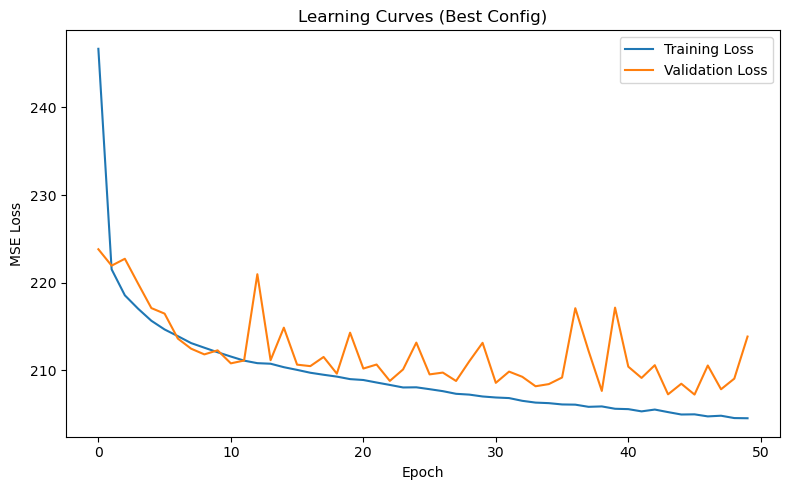

In [93]:
# Learning curves for the winner
# quick over/underfitting sanity check

# --- Plot learning curves for the winning trial ---
plt.figure(figsize=(8,5))
plt.plot(best_result['train_losses'], label='Training Loss')
plt.plot(best_result['valid_losses'], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.title('Learning Curves (Best Config)')
plt.legend(); plt.tight_layout()
plt.show()

No overfitting.


In [94]:
# Baseline = predict the TRAINING mean for everyone
train_mean = y_train.mean().item()  # scalar float

# Predict that constant for each row
y_valid_pred_base = torch.full_like(y_valid, fill_value=train_mean)
y_test_pred_base  = torch.full_like(y_test,  fill_value=train_mean)

# RMSE = sqrt(MSE)
baseline_valid_rmse = torch.sqrt(torch.mean((y_valid - y_valid_pred_base) ** 2)).item()
baseline_test_rmse  = torch.sqrt(torch.mean((y_test  - y_test_pred_base)  ** 2)).item()

print(f"Baseline (mean) RMSE — Valid: {baseline_valid_rmse:.4f} | Test: {baseline_test_rmse:.4f}")


Baseline (mean) RMSE — Valid: 18.1724 | Test: 18.2286


Our model (Test RMSE: 14.4734) has performed well than the baseline model (Test RMSE: 18.2286).
